# BBC TEXT CLASSIFICATION

# Introduction
**Source** : [https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification](https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification)

This data contains a collections of news articles organized into multiple categories, including entertainment, sport,... Each entry in the dataset consists of two key components:
1. **labes**: Indicating the category of the news.
2. **data**: The textual content of the news article, providing detailed information on the topic.

### Objective 
Evaluate and compare the performance of vectorization techniques (CountVectorizer, TfidfVectorizer, KNN) with ANN and KNN for the **classification** task.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbc-full-text-document-classification/bbc_data.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [3]:
def plot_accuracy_and_loss(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_accuracy) + 1)
    
    ax1.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    ax1.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid()
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax2.plot(epochs, train_loss, 'b', label='Training Loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

def plot_classification_report_and_confusion_matrix(y_val, y_pred, labels):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    axes[1].axis('off')
    report = classification_report(y_val, y_pred, target_names=labels, output_dict=True)
    
    report_data = []
    for i, label in enumerate(labels):
        row = report[label]
        true_positives = cm[i, i]
        total_label_count = row['support']
        accuracy_label = (true_positives / total_label_count) * 100
        report_data.append([label, f"{row['precision']:.4f}", f"{row['recall']:.4f}", f"{row['f1-score']:.4f}", f"{true_positives}/{total_label_count} = {accuracy_label:.2f}%"])

    overall = report.get('accuracy', None)
    if overall:
        report_data.append([None, None, None, None, f"{overall:.4f}"])

    table = axes[1].table(cellText=report_data, 
                         colLabels=['Label', 'Precision', 'Recall', 'F1-Score', 'Accuracy'],
                         loc='center', cellLoc='center', colColours=['#f1f1f1']*5)
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.tight_layout()
    plt.show()

def plot_knn_accuracy(accuracies):
    plt.plot(range(3, 11), accuracies, marker='o', linestyle='-', color='b')
    plt.title('KNN Accuracy vs Number of Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(range(3, 11))
    plt.show()

class PrintEveryNthEpoch(tf.keras.callbacks.Callback):
    def __init__(self, n=5):
        super().__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:
            formatted_logs = {key: f"{value:.5f}" if isinstance(value, (int, float)) else value for key, value in logs.items()}
            print(f"Epoch {epoch + 1}: {formatted_logs}")

print_callback = PrintEveryNthEpoch(n=5)

# Data Understanding

In [4]:
df = pd.read_csv("/kaggle/input/bbc-full-text-document-classification/bbc_data.csv")
df

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [5]:
df.isna().sum()

data      0
labels    0
dtype: int64

In [6]:
df['labels'].value_counts()

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [7]:
all_words = []
for sentence in df['data']:
    all_words.extend(sentence.split())
vocab_count = len(set(all_words))
print(f"Number of unique words in the vocabulary: {vocab_count}")

Number of unique words in the vocabulary: 64151


In [8]:
df['text_length'] = df['data'].apply(lambda x: len(x.split()))
print(df['text_length'].describe()) 

count    2225.000000
mean      384.166292
std       238.141890
min        89.000000
25%       246.000000
50%       332.000000
75%       472.000000
max      4432.000000
Name: text_length, dtype: float64


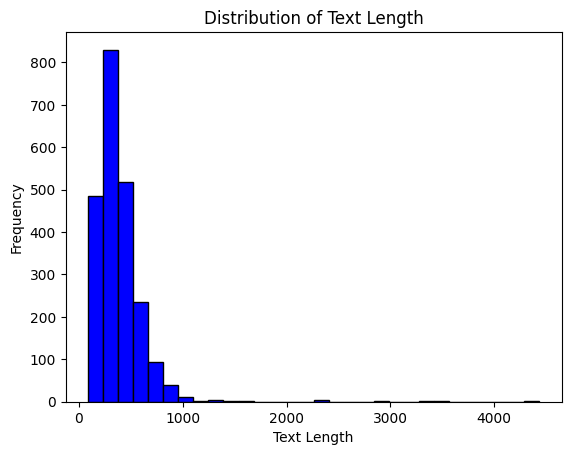

In [9]:
plt.hist(df['text_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

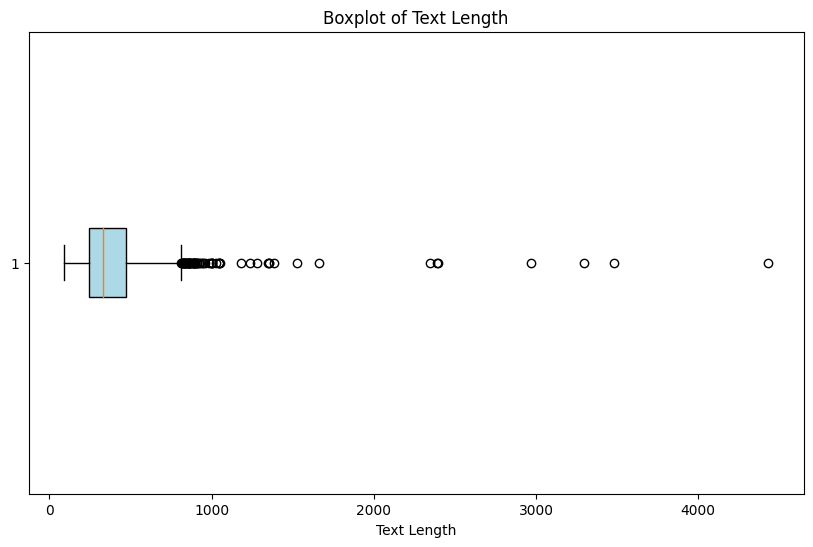

In [10]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['text_length'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot of Text Length')
plt.xlabel('Text Length')
plt.show()

# Data processing

In [11]:
stop_words = stopwords.words('english')

def data_cleaning(text):
    # Convert to lower
    text = text.lower()
    # Remove stopwords
    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)
    # Remove punctuations
    text = ''.join(char for char in text if char not in string.punctuation)
    # Remove non-alphabetic characters 
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = ' '.join(text.split())
    return text

In [12]:
df['data_cleaned'] = df['data'].apply(data_cleaning)
df.head()

,data,labels,text_length,data_cleaned
0,Musicians to tackle US red tape Musicians gro...,entertainment,378,musicians tackle us red tape musicians groups ...
1,"U2s desire to be number one U2, who have won ...",entertainment,838,us desire number one u three prestigious gramm...
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment,358,rocker doherty onstage fight rock singer pete ...
3,Snicket tops US box office chart The film ada...,entertainment,177,snicket tops us box office chart film adaptati...
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,251,oceans twelve raids box office oceans twelve c...


In [13]:
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

Lower Bound: -93.0
Upper Bound: 811.0


In [14]:
df_cleaned = df[(df['text_length'] >= lower_bound) & (df['text_length'] <= upper_bound)]

print("Original Data Size:", df.shape[0])
print("Cleaned Data Size:", df_cleaned.shape[0])
df_cleaned

Original Data Size: 2225
Cleaned Data Size: 2159


,data,labels,text_length,data_cleaned
0,Musicians to tackle US red tape Musicians gro...,entertainment,378,musicians tackle us red tape musicians groups ...
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment,358,rocker doherty onstage fight rock singer pete ...
3,Snicket tops US box office chart The film ada...,entertainment,177,snicket tops us box office chart film adaptati...
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,251,oceans twelve raids box office oceans twelve c...
5,Landmark movies of 2004 hailed US film profes...,entertainment,333,landmark movies hailed us film professionals d...
...,...,...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech,460,warning windows word files writing microsoft w...
2221,Fast lifts rise into record books Two high-sp...,tech,384,fast lifts rise record books two highspeed lif...
2222,Nintendo adds media playing to DS Nintendo is...,tech,293,nintendo adds media playing ds nintendo releas...
2223,Fast moving phone viruses appear Security fir...,tech,332,fast moving phone viruses appear security firm...


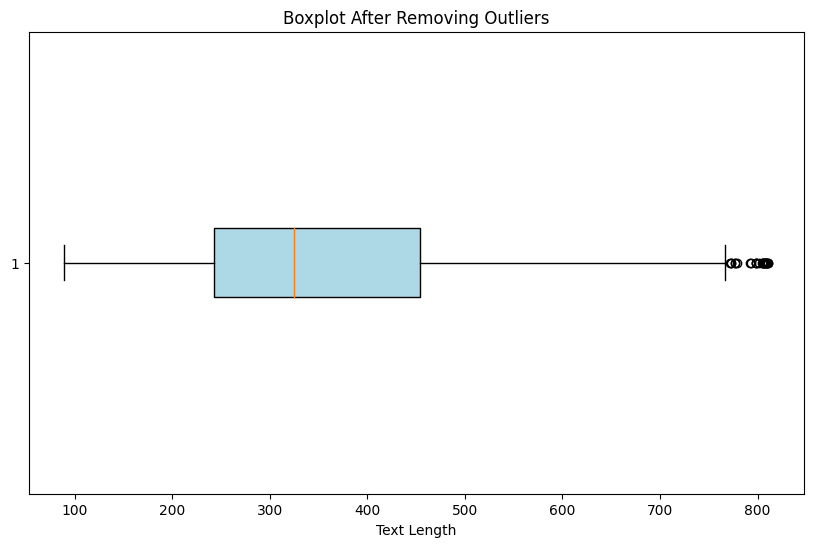

In [15]:
plt.figure(figsize=(10, 6))
plt.boxplot(df_cleaned['text_length'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot After Removing Outliers')
plt.xlabel('Text Length')
plt.show()

In [16]:
top_words_per_label = {}
all_words = []
num_top = 20

for label, group in df.groupby('labels'):
    word_counts = {}
    for sentence in group['data_cleaned']:
        words = sentence.split()
        all_words.extend(words)
        for word in words:
            word_counts[word] = word_counts[word] + 1 if word in word_counts else 1
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:num_top]
    top_words_per_label[label] = sorted_words

vocab_count = len(set(all_words))
print(f"Number of unique words in the vocabulary: {vocab_count}\n")
for label, top_words in top_words_per_label.items():
    print(f"Top {num_top} words for {label}:")
    for word, count in top_words:
        print(f"   {word}: {count}", end="")
    print('\n---------')

Number of unique words in the vocabulary: 31541

Top 20 words for business:
   said: 1680   us: 801   year: 620   mr: 600   bn: 572   would: 463   also: 440   market: 420   new: 416   growth: 384   company: 366   last: 365   economy: 352   firm: 321   sales: 316   bank: 316   could: 311   economic: 310   government: 298   oil: 294
---------
Top 20 words for entertainment:
   said: 825   film: 732   best: 590   music: 430   also: 398   us: 377   one: 354   years: 335   new: 322   show: 308   awards: 273   year: 269   last: 252   first: 251   award: 233   number: 227   uk: 211   two: 209   films: 209   director: 206
---------
Top 20 words for politics:
   said: 2240   mr: 1686   would: 1051   government: 644   labour: 616   people: 593   election: 565   blair: 509   party: 480   also: 452   new: 430   minister: 393   could: 384   told: 359   brown: 327   public: 321   plans: 311   uk: 303   one: 292   howard: 292
---------
Top 20 words for sport:
   said: 941   i: 501   game: 475   first

In [17]:
df = df_cleaned
X = df['data_cleaned']
y = df['labels']

# CountVectorizer 

It simply counts how many times each word appears in each document.

Each document is represented by a vector where each element corresponds to the frequency of a specific word in the document.

In [18]:
vect = CountVectorizer()
vect.fit(X)

CountVectorizer()

## CountVectorizer - ANN

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

X_train = vect.transform(X_train).toarray()
X_val = vect.transform(X_val).toarray()
X_test = vect.transform(X_test).toarray()

y_train = pd.get_dummies(y_train, dtype=int)
y_val = pd.get_dummies(y_val, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [20]:
input_shape = X_train.shape[1]

model = Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │       478,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,469 (1.83 MB)

 Trainable params: 478,469 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
            X_train, y_train, epochs=50, 
            batch_size=256,
            validation_data=(X_val,y_val),
            callbacks=[early_stopping, print_callback],
            verbose=0
        )

Epoch 5: {'accuracy': '0.99934', 'loss': '0.41916', 'val_accuracy': '0.95833', 'val_loss': '0.49138'}
Epoch 10: {'accuracy': '1.00000', 'loss': '0.23770', 'val_accuracy': '0.97685', 'val_loss': '0.34277'}
Epoch 15: {'accuracy': '1.00000', 'loss': '0.18017', 'val_accuracy': '0.97222', 'val_loss': '0.28026'}
Epoch 20: {'accuracy': '1.00000', 'loss': '0.14626', 'val_accuracy': '0.97685', 'val_loss': '0.24210'}
Epoch 25: {'accuracy': '1.00000', 'loss': '0.12243', 'val_accuracy': '0.97685', 'val_loss': '0.21495'}
Epoch 30: {'accuracy': '1.00000', 'loss': '0.10459', 'val_accuracy': '0.97685', 'val_loss': '0.19431'}
Epoch 35: {'accuracy': '1.00000', 'loss': '0.09068', 'val_accuracy': '0.97685', 'val_loss': '0.17811'}
Epoch 40: {'accuracy': '1.00000', 'loss': '0.07952', 'val_accuracy': '0.97685', 'val_loss': '0.16504'}
Epoch 45: {'accuracy': '1.00000', 'loss': '0.07043', 'val_accuracy': '0.97222', 'val_loss': '0.15426'}
Epoch 50: {'accuracy': '1.00000', 'loss': '0.06289', 'val_accuracy': '0.97

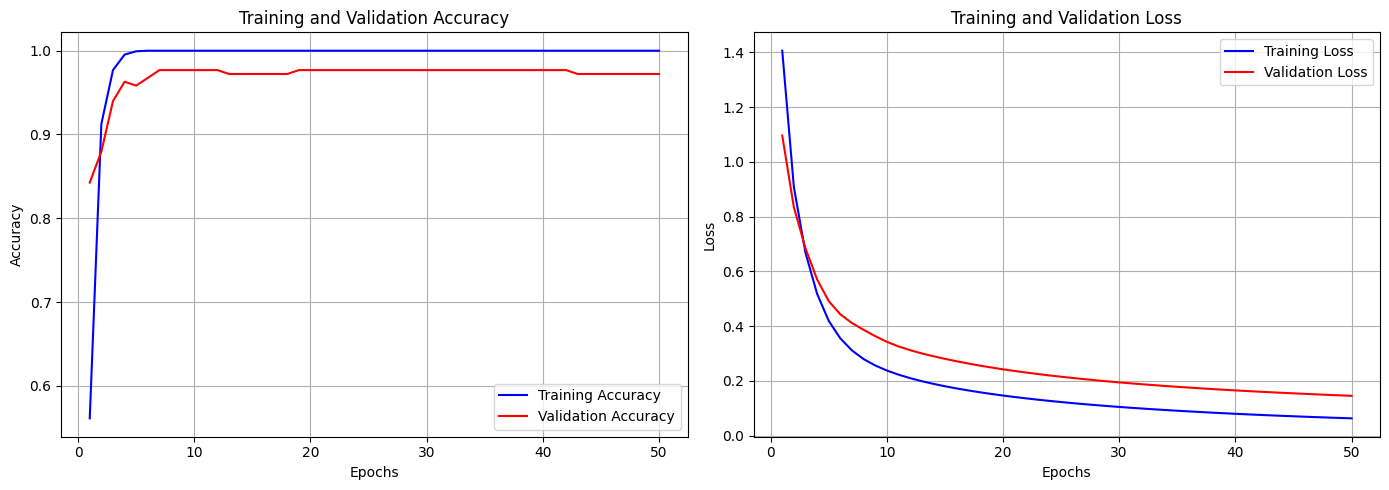

In [22]:
plot_accuracy_and_loss(history)

In [23]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_processed = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


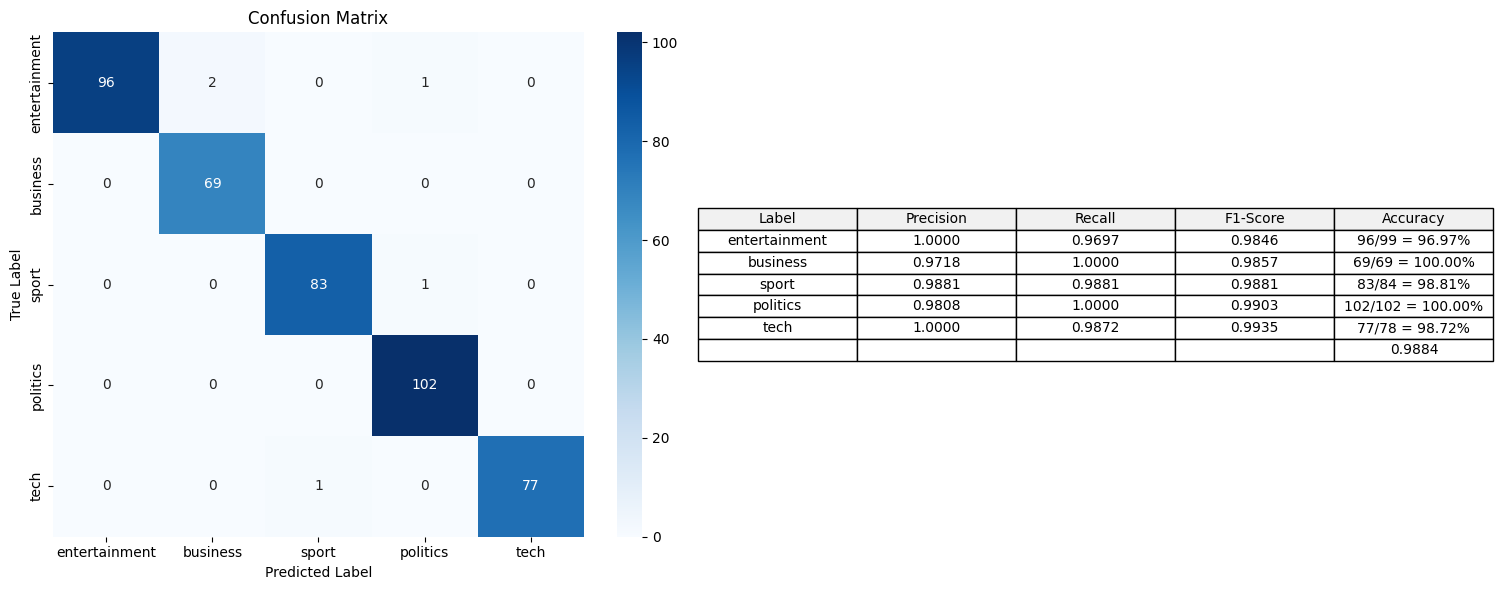

In [24]:
plot_classification_report_and_confusion_matrix(y_test_processed, y_pred, df["labels"].unique())

**Remark:** 
This CountVectorizer with ANN gives very good results, with Precision, Recall, F1-Score, and Accuracy all higher than 0.96. Additionally, the results are similar across all labels, with little variation.

## CountVectorizer - KNN

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = vect.transform(X_train).toarray()
X_test = vect.transform(X_test).toarray()

y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

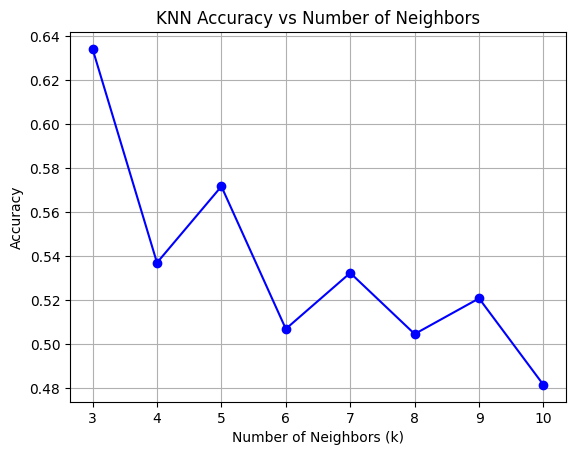

In [26]:
accuracies = []
best_accuracy = 0
y_best_pred = 0

for i in range(3, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        y_best_pred = y_pred

plot_knn_accuracy(accuracies)
y_best_pred = np.argmax(y_best_pred, axis=1)
y_test_processed = np.argmax(y_test, axis=1)

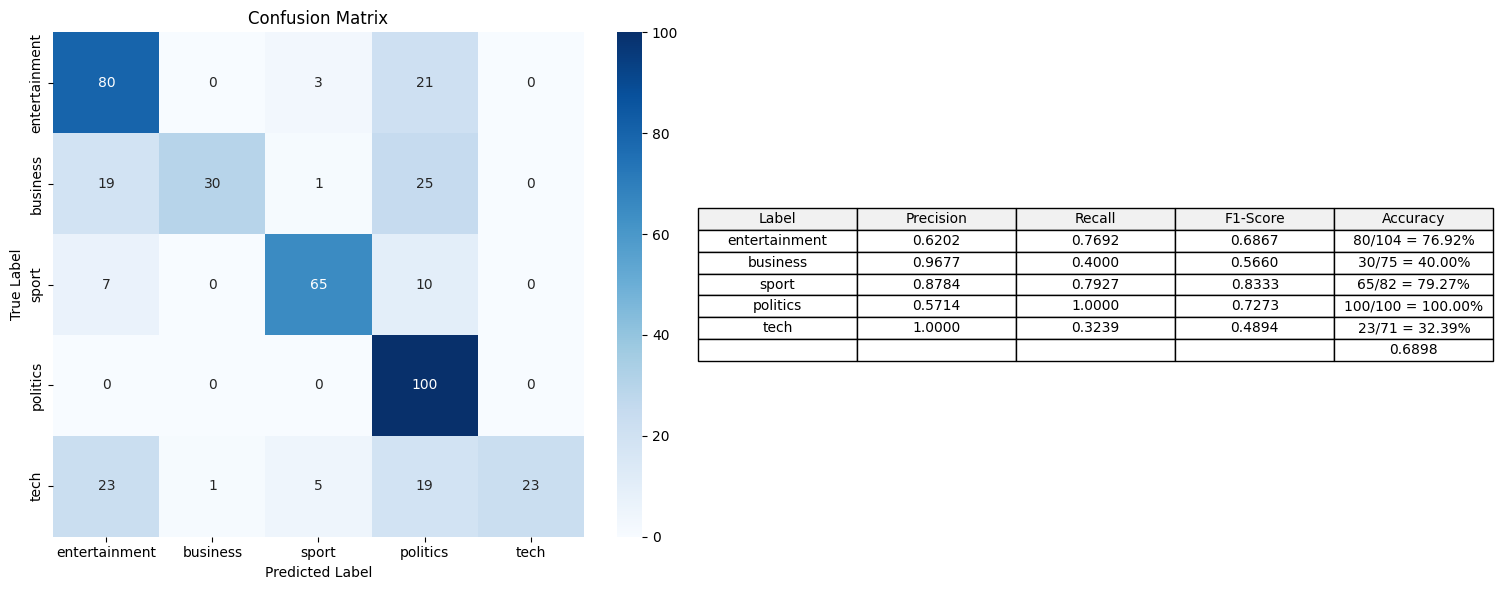

In [27]:
plot_classification_report_and_confusion_matrix(y_test_processed, y_best_pred, df["labels"].unique())

**Remark:** 
This CountVectorizer with KNN gives not good results, the general accuracy is just about 69%. Additionally, the results are unbalance and different across all labels, from 32% to 100% accuracy.

# TfidfVectorizer

TF (Term Frequency): Measures how often a word appears in a document.

IDF (Inverse Document Frequency): Measures how common or rare a word is across all documents in the corpus. It reduces the weight of words that appear frequently across many documents (i.e., common words) and increases the weight of words that are unique to a few documents.

The TF-IDF score for each word in each document is calculated by multiplying the term frequency by the inverse document frequency.

$\text{TF-IDF}(t,d)=\text{TF}(t,d) \times \text{IDF}(t)$

$t$ is a term (word); $d$ is a document; $\text{TF}(t,d)$ is the frequency of term $t$ in document $d$; $\text{IDF}(t)$ is the inverse document frequency of $t$ across all documents.

In [28]:
tfid = TfidfVectorizer()
tfid.fit(X)

TfidfVectorizer()

## TfidfVectorizer - ANN

In [29]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

X_train = tfid.transform(X_train).toarray()
X_val = tfid.transform(X_val).toarray()
X_test = tfid.transform(X_test).toarray()

y_train = pd.get_dummies(y_train, dtype=int)
y_val = pd.get_dummies(y_val, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [30]:
input_shape = X_train.shape[1]

model = Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │       478,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,469 (1.83 MB)

 Trainable params: 478,469 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history = model.fit(
            X_train, y_train, epochs=50, 
            batch_size=256,
            validation_data=(X_val,y_val),
            callbacks=[early_stopping, print_callback],
            verbose=0
        )

Epoch 5: {'accuracy': '0.90735', 'loss': '1.25127', 'val_accuracy': '0.80093', 'val_loss': '1.27256'}
Epoch 10: {'accuracy': '0.99669', 'loss': '0.82153', 'val_accuracy': '0.94907', 'val_loss': '0.92355'}
Epoch 15: {'accuracy': '0.99868', 'loss': '0.51368', 'val_accuracy': '0.97685', 'val_loss': '0.66183'}
Epoch 20: {'accuracy': '0.99868', 'loss': '0.33243', 'val_accuracy': '0.98148', 'val_loss': '0.49657'}
Epoch 25: {'accuracy': '1.00000', 'loss': '0.22665', 'val_accuracy': '0.97685', 'val_loss': '0.39314'}
Epoch 30: {'accuracy': '1.00000', 'loss': '0.16314', 'val_accuracy': '0.97685', 'val_loss': '0.32559'}
Epoch 35: {'accuracy': '1.00000', 'loss': '0.12366', 'val_accuracy': '0.97685', 'val_loss': '0.27938'}
Epoch 40: {'accuracy': '1.00000', 'loss': '0.09783', 'val_accuracy': '0.97685', 'val_loss': '0.24624'}
Epoch 45: {'accuracy': '1.00000', 'loss': '0.07995', 'val_accuracy': '0.98148', 'val_loss': '0.22152'}
Epoch 50: {'accuracy': '1.00000', 'loss': '0.06701', 'val_accuracy': '0.98

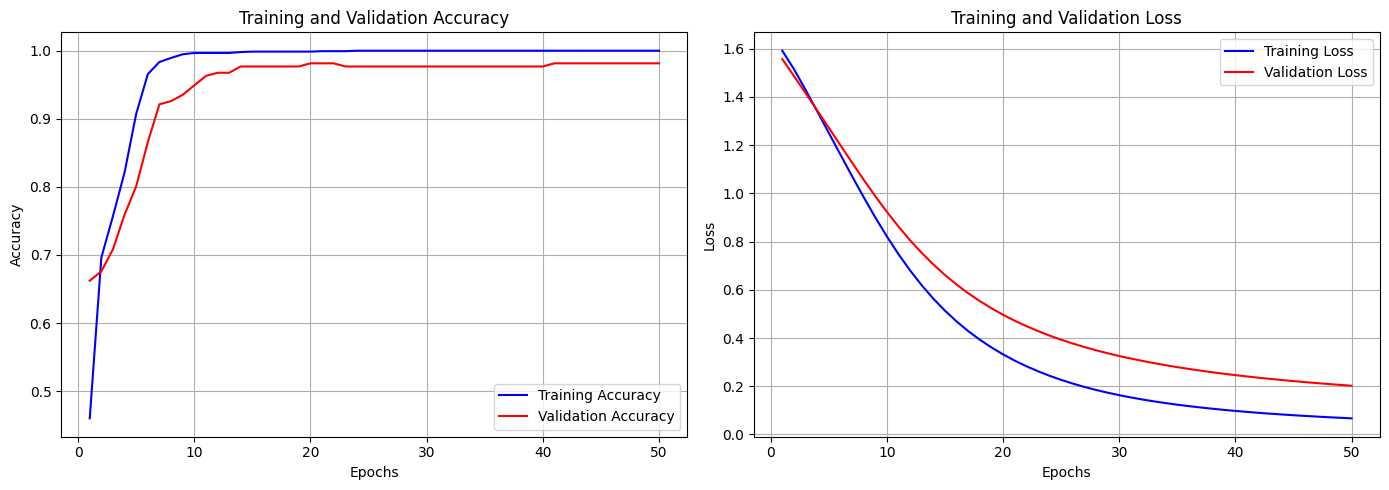

In [32]:
plot_accuracy_and_loss(history)

In [33]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_processed = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


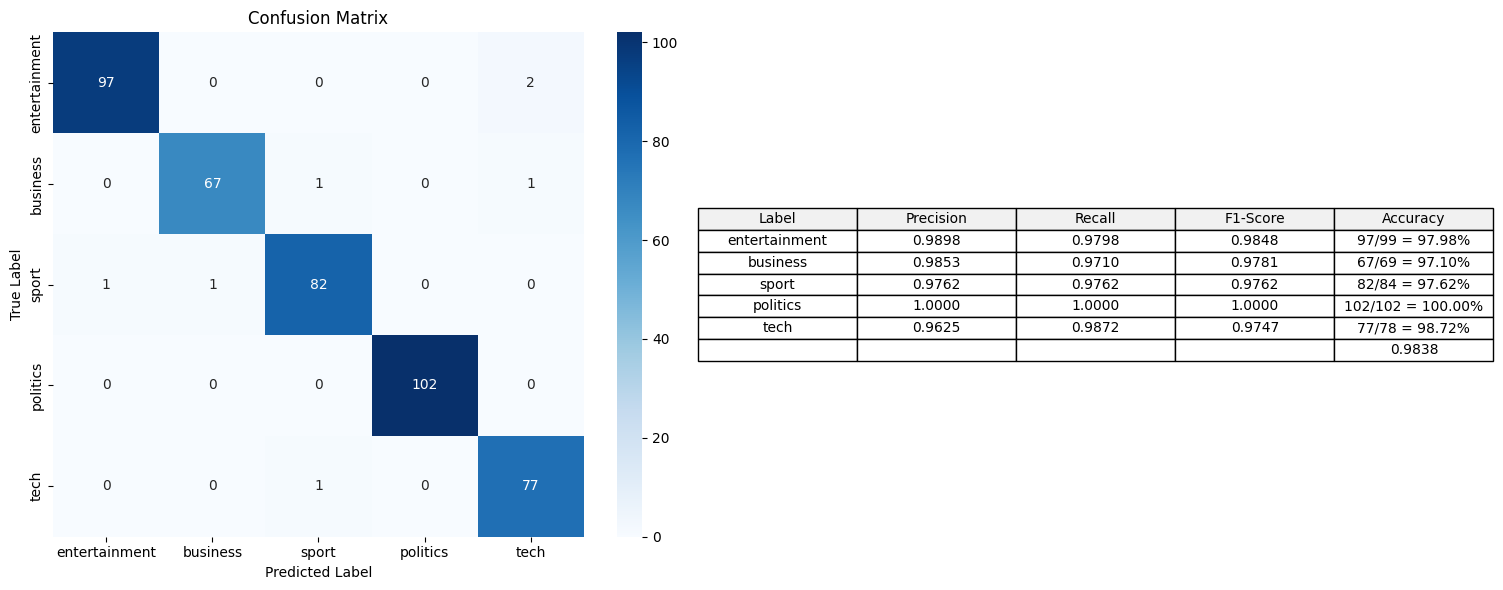

In [34]:
plot_classification_report_and_confusion_matrix(y_test_processed, y_pred, df["labels"].unique())

**Remark:** 
This TfidfVectorizer with ANN gives very good results, with Precision, Recall, F1-Score, and Accuracy all higher than 0.95. Additionally, the results are similar across all labels, with little variation.

## TfidfVectorizer - KNN

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = tfid.transform(X_train).toarray()
X_test = tfid.transform(X_test).toarray()

y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

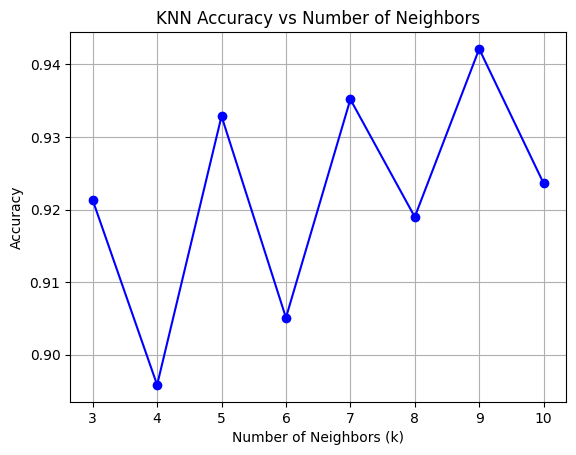

In [36]:
accuracies = []
best_accuracy = 0
y_best_pred = 0

for i in range(3, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        y_best_pred = y_pred

plot_knn_accuracy(accuracies)
y_best_pred = np.argmax(y_best_pred, axis=1)
y_test_processed = np.argmax(y_test, axis=1)

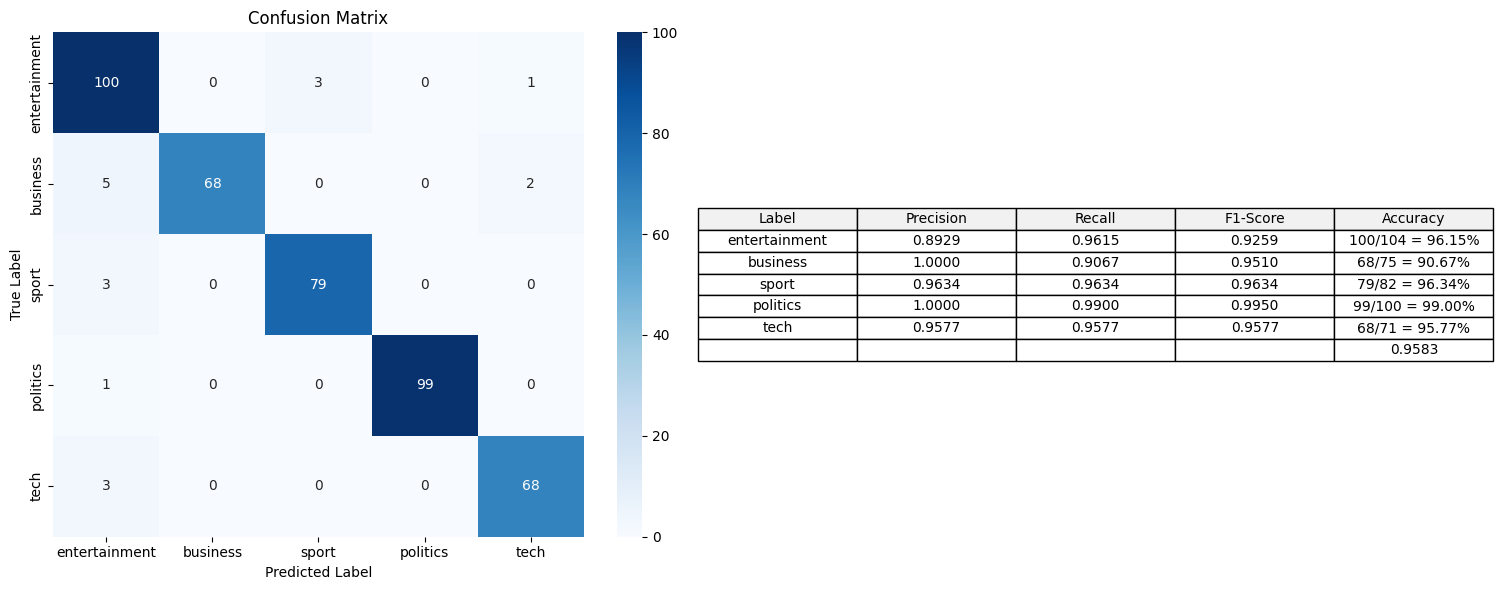

In [37]:
plot_classification_report_and_confusion_matrix(y_test_processed, y_best_pred, df["labels"].unique())

**Remark:** 
This TfidfVectorizer with KNN gives very good results, with Precision, Recall, F1-Score, and Accuracy all higher than 0.89. Additionally, the results are similar across all labels, with little variation.

# Word2Vec

In Word2Vec, words are represented as dense vectors (arrays of numbers), unlike sparse representations (like the bag-of-words models).

These dense vectors capture semantic meanings based on the context in which words appear.

Word2Vec uses two main approaches (or models) to learn word vectors:
- Skip-gram: Given a target word, predict the surrounding context words. This model is good for handling rare words.
- Continuous Bag of Words (CBOW): Given a set of context words, predict the target word. This model is good for frequent words.

The "context" refers to the words surrounding a given target word in a sentence or document. Word2Vec learns word representations based on how frequently words appear in similar contexts.

Words that appear in similar contexts will have similar vector representations, which allows the model to capture semantic relationships like synonyms or related concepts.

## Word2Vec - ANN

In [38]:
X_tokenized = [word_tokenize(doc) for doc in X]

word2vec = Word2Vec(sentences=X_tokenized, vector_size=100, window=5, min_count=1, workers=4)

def document_vector(doc):
    vectors = [word2vec.wv[word] for word in doc if word in word2vec.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec.vector_size)

X_vectorized = np.array([document_vector(doc) for doc in X_tokenized])

In [39]:
X_train, X_temp, y_train, y_temp = train_test_split(X_vectorized, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

y_train = pd.get_dummies(y_train, dtype=int)
y_val = pd.get_dummies(y_val, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [40]:
input_shape = X_train.shape[1]

model = Sequential()
model.add(Input(shape=(input_shape,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(5, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,797 (7.02 KB)

 Trainable params: 1,797 (7.02 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(
            X_train, y_train, epochs=50, 
            batch_size=256,
            validation_data=(X_val,y_val),
            callbacks=[early_stopping, print_callback],
            verbose=0
        )

Epoch 5: {'accuracy': '0.24950', 'loss': '1.57677', 'val_accuracy': '0.31481', 'val_loss': '1.58254'}
Epoch 10: {'accuracy': '0.44540', 'loss': '1.54339', 'val_accuracy': '0.40278', 'val_loss': '1.54629'}
Epoch 15: {'accuracy': '0.44408', 'loss': '1.50399', 'val_accuracy': '0.46759', 'val_loss': '1.50156'}
Epoch 20: {'accuracy': '0.48180', 'loss': '1.45400', 'val_accuracy': '0.48611', 'val_loss': '1.44262'}
Epoch 25: {'accuracy': '0.47981', 'loss': '1.39917', 'val_accuracy': '0.51389', 'val_loss': '1.38001'}
Epoch 30: {'accuracy': '0.47783', 'loss': '1.34615', 'val_accuracy': '0.52778', 'val_loss': '1.32356'}
Epoch 35: {'accuracy': '0.48577', 'loss': '1.29433', 'val_accuracy': '0.52315', 'val_loss': '1.26834'}
Epoch 40: {'accuracy': '0.49901', 'loss': '1.24758', 'val_accuracy': '0.54167', 'val_loss': '1.22351'}
Epoch 45: {'accuracy': '0.51754', 'loss': '1.20549', 'val_accuracy': '0.56019', 'val_loss': '1.17946'}
Epoch 50: {'accuracy': '0.53673', 'loss': '1.16776', 'val_accuracy': '0.56

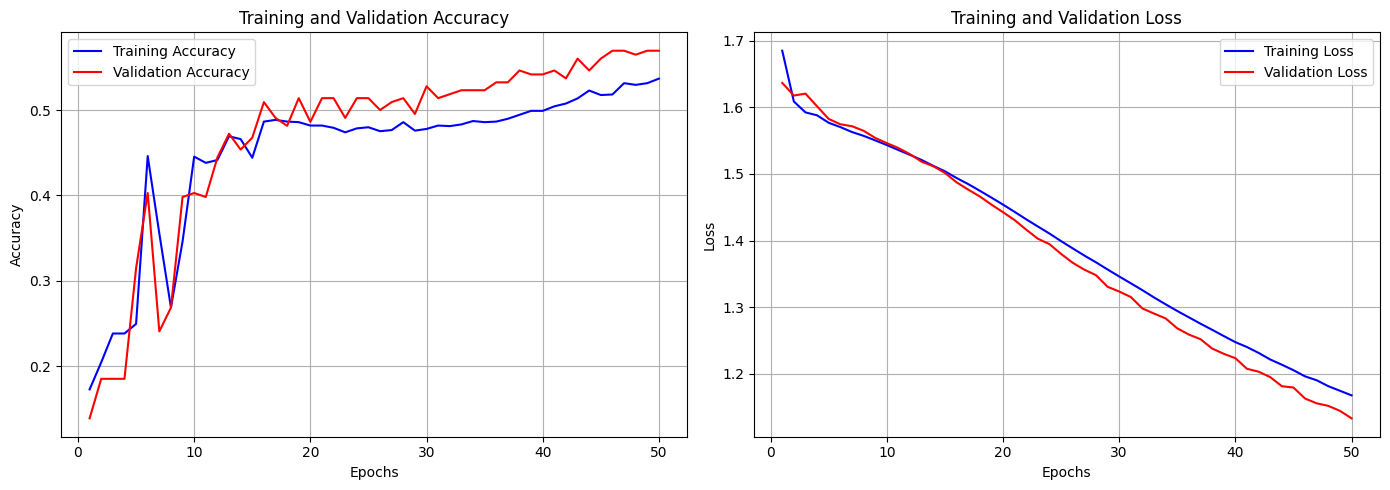

In [42]:
plot_accuracy_and_loss(history)

In [43]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_processed = np.argmax(y_test, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


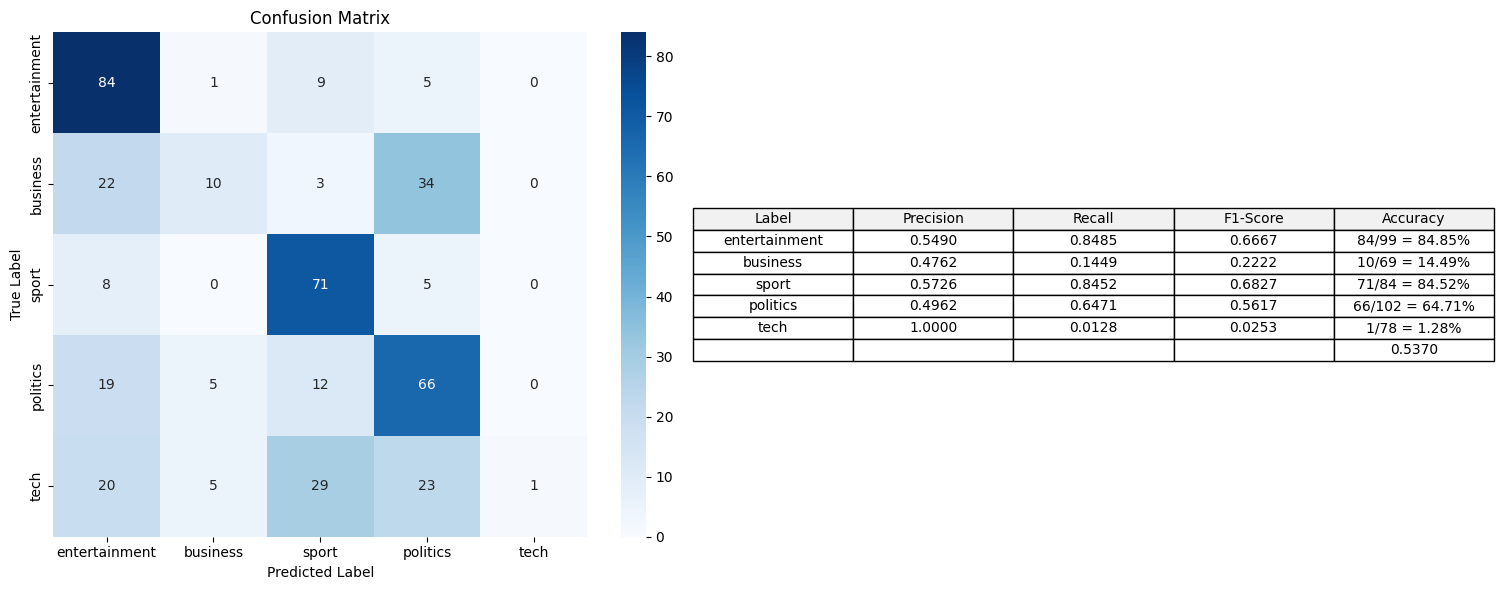

In [44]:
plot_classification_report_and_confusion_matrix(y_test_processed, y_pred, df["labels"].unique())

**Remark:** 
This Word2Vec with ANN gives bad results, the general accuracy is just about 65%. Additionally, the results are unbalance and different across all labels, from 44% to 76% accuracy.

## Word2Vec - KNN

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

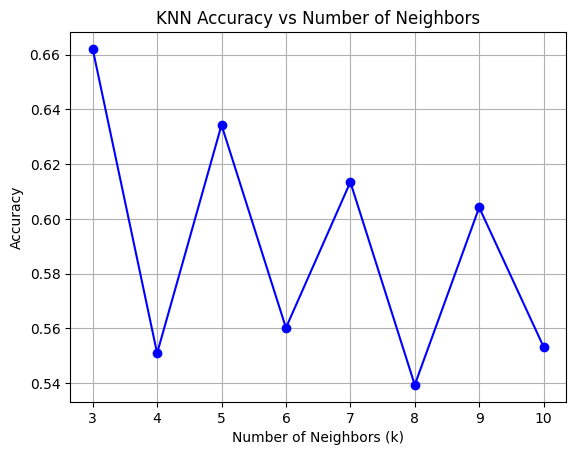

In [46]:
accuracies = []
best_accuracy = 0
y_best_pred = 0

for i in range(3, 11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        y_best_pred = y_pred

plot_knn_accuracy(accuracies)
y_best_pred = np.argmax(y_best_pred, axis=1)
y_test_processed = np.argmax(y_test, axis=1)

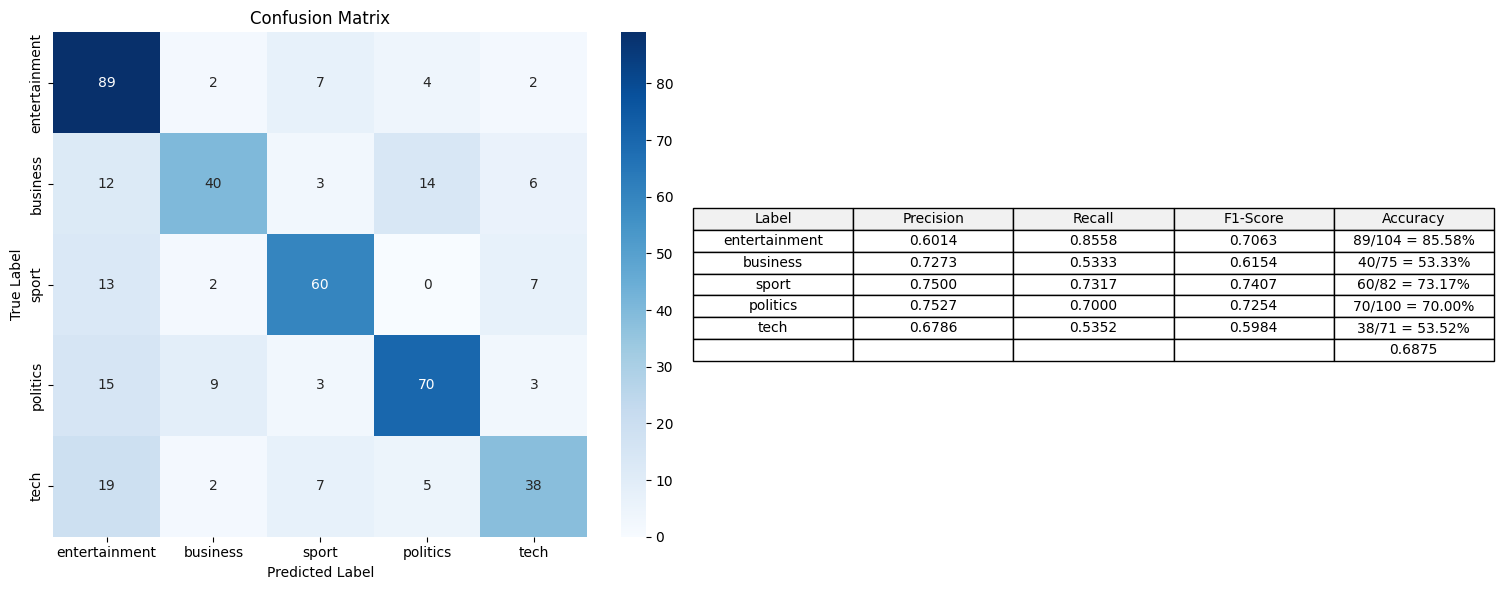

In [47]:
plot_classification_report_and_confusion_matrix(y_test_processed, y_best_pred, df["labels"].unique())

**Remark:** 
This Word2Vec with KNN gives not good results, the general accuracy is just about 69%. Additionally, the results are unbalance and different across all labels, from 52% to 85% accuracy.

# Remark

### Performance

- ANN models perform best with CountVectorizer and TfidfVectorizer, with CountVectorizer slightly outperforming TfidfVectorizer.
- For KNN, TfidfVectorizer is superior to CountVectorizer and Word2Vec.
- Word2Vec's performance is significantly lower in both ANN and KNN.

### Explain

#### Data Sparsity:
- CountVectorizer and TfidfVectorizer produce sparse vectors, which are effective for certain algorithms like ANN that can handle large feature spaces.
- Word2Vec produces dense vectors, which may lose information in aggregation.

#### Task Dependence
- CountVectorizer and TfidfVectorizer emphasize lexical differences (important for classification).
- Word2Vec emphasizes semantic similarity, which may not align with KNN or ANN's goals in this dataset.

#### Dataset Size and Quality
- Word2Vec benefits from a large corpus for training embeddings. If your dataset is small, the learned vectors may not effectively capture semantic relationships.
